<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load modules and Set constants

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os, cv2, glob, zipfile
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt

In [3]:
WIDTH, HEIGHT = 8, 8

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '34',
    'date' : '07-27-2021',
    'description' : 'Draw similar bimap images into one image'
    }

ROOT_DIR = os.path.join('/content')

BITMAP_DIR = os.path.join(ROOT_DIR, 'Bitmap')
IMAGE_DIR = os.path.join(ROOT_DIR, 'Image_Files')

EXPERIMENT_DIR = os.path.join(ROOT_DIR, 'drive', 'MyDrive', '1_University', 'PiLab', 'Experiment')
DATA_DIR = os.path.join(EXPERIMENT_DIR, 'Data')
RESULT_DIR = os.path.join(EXPERIMENT_DIR, 'Results')

os.chdir(RESULT_DIR)
curr_result_name = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Results"
if (curr_result_name not in os.listdir()):
    os.mkdir(curr_result_name)

CURR_RESULT_DIR = os.path.join(RESULT_DIR, curr_result_name)
os.chdir(CURR_RESULT_DIR)

with open('Description.txt', 'w') as f:
    f.write(EXPERIMENT_DATA['description'])

print(f'ROOT_DIR:        {ROOT_DIR}')
print(f'BITMAP_DIR:      {BITMAP_DIR}')
print(f'IMAGE_DIR:       {IMAGE_DIR}')
print(f'EXPERIMENT_DIR:  {EXPERIMENT_DIR}')
print(f'DATA_DIR:        {DATA_DIR}')
print(f'RESULT_DIR:      {RESULT_DIR}')
print(f'CURR_RESULT_DIR: {CURR_RESULT_DIR}')

ROOT_DIR:        /content
BITMAP_DIR:      /content/Bitmap
IMAGE_DIR:       /content/Image_Files
EXPERIMENT_DIR:  /content/drive/MyDrive/1_University/PiLab/Experiment
DATA_DIR:        /content/drive/MyDrive/1_University/PiLab/Experiment/Data
RESULT_DIR:      /content/drive/MyDrive/1_University/PiLab/Experiment/Results
CURR_RESULT_DIR: /content/drive/MyDrive/1_University/PiLab/Experiment/Results/Trajectory_Clusetring_34_07-27-2021_Results


# Load Data

In [6]:
os.chdir(ROOT_DIR)
zipfile.ZipFile(DATA_DIR + "/Bitmap.zip").extractall(ROOT_DIR)

In [7]:
os.chdir(ROOT_DIR)
zipfile.ZipFile(DATA_DIR + "/Image_Files.zip").extractall(ROOT_DIR)

In [8]:
os.chdir(BITMAP_DIR)
print(sorted(glob.glob('*png'))[:10])

['0th data.png', '1000000th data.png', '1000064th data.png', '1000128th data.png', '1000192th data.png', '1000256th data.png', '1000320th data.png', '100032th data.png', '1000384th data.png', '1000448th data.png']


<Figure size 432x288 with 0 Axes>

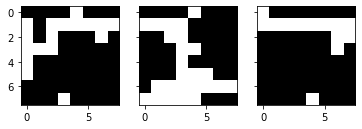

In [10]:
os.chdir(BITMAP_DIR)
file_names = sorted(glob.glob('*png'))

bitmap_data = [ ]
for file in file_names:
    bitmap_data.append(cv2.imread(file, cv2.IMREAD_GRAYSCALE))

plt.gray()
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)
ax[0].imshow(bitmap_data[0])
ax[1].imshow(bitmap_data[1])
ax[2].imshow(bitmap_data[2])

plt.show()

In [11]:
X_train = np.array(bitmap_data).astype('float32') / 255.
X_train = np.reshape(X_train, (-1, HEIGHT, WIDTH, 1))

# Load Models

In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
os.chdir(os.path.join(EXPERIMENT_DIR, 'Models', 'Bitmap'))
encoder = keras.models.load_model('encoder.h5')
decoder =  keras.models.load_model('decoder.h5')
auto_encoder = keras.models.load_model('auto_encoder.h5')

# Get similar data

In [14]:
low_dimension = encoder(X_train)

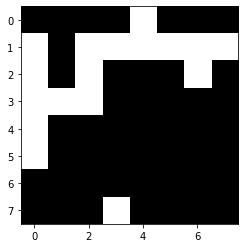

In [15]:
plt.imshow(bitmap_data[0])
plt.savefig('First_Bitmap.png', dpi = 100)
plt.show()

In [16]:
def plotImage(image_list, row, col, file_name = None, super_title = None):
    n = len(image_list)
    if (row == 1 and col == 1):
        plt.imshow(image_list)
    else: # row > 1 or col > 1
        if (row == 1):
            fig, ax = plt.subplots(1, col, sharex = True, sharey = True)
            for i in range(col):
                ax[i].imshow(image_list[i])
        else:
            fig, ax = plt.subplots(row, col, sharex = True, sharey = True)
            for i in range(row):
                for j in range(col):
                    ax[i][j].imshow(image_list[i][j])

        if (super_title):
            plt.suptitle(super_title, fontsize = 20)
    
    if (file_name):
        plt.savefig(file_name, dpi = 100)

    plt.show()

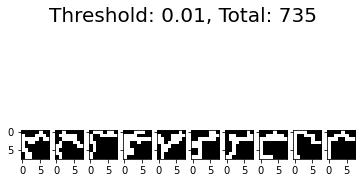

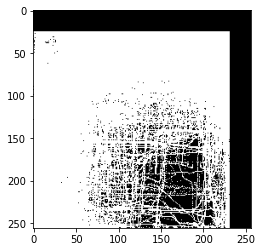

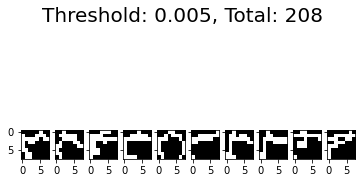

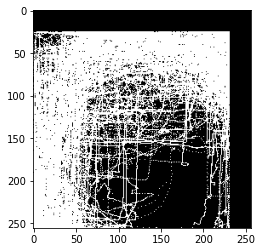

In [21]:
from scipy.spatial import distance

thresholds = [0.01, 0.005]
for threshold in thresholds:
    count = 0
    similar_bitmaps = []
    similar_bitmap_file_name = []
    for i in range(1, len(bitmap_data)):
        if (distance.cosine(low_dimension[0], low_dimension[i]) < threshold):
            similar_bitmap_file_name.append(file_names[i])
            if (count < 10):
                similar_bitmaps.append(bitmap_data[i])
            count += 1
    
    os.chdir(CURR_RESULT_DIR)
    plotImage(similar_bitmaps, 1, len(similar_bitmaps), file_name = f'Result({threshold}).png', super_title = f'Threshold: {threshold}, Total: {count}')

    map_table = pd.read_csv(DATA_DIR + '/Map_Table.csv', header = 0)

    os.chdir(IMAGE_DIR)

    total_image = [ [ 0 for _ in range(256) ] for _ in range(256) ]
    for file_name in similar_bitmap_file_name:
        image_file_name = map_table.loc[map_table[' LowDimNumber'] == int(file_name.split('th')[0])].iloc[0]['ImageNumber']
        curr_image = cv2.imread(f'Geolife_trajectory{image_file_name}.png', cv2.IMREAD_GRAYSCALE)
        for i in range(len(curr_image)):
            for j in range(len(curr_image[0])):
                if (curr_image[i][j] > 0):
                    total_image[i][j] = 255

    os.chdir(CURR_RESULT_DIR)
    plotImage(total_image, 1, 1, file_name = f'Result of one image_{threshold}.png')

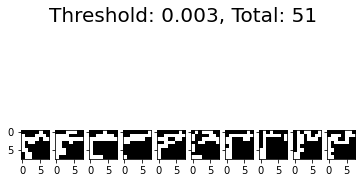

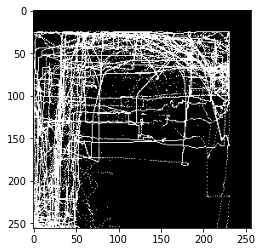

In [22]:
from scipy.spatial import distance

threshold, count = 0.003, 0
similar_bitmaps = []
similar_bitmap_file_name = []
for i in range(1, len(bitmap_data)):
    if (distance.cosine(low_dimension[0], low_dimension[i]) < threshold):
        similar_bitmap_file_name.append(file_names[i])
        if (count < 10):
            similar_bitmaps.append(bitmap_data[i])
        count += 1

os.chdir(CURR_RESULT_DIR)
plotImage(similar_bitmaps, 1, len(similar_bitmaps), file_name = f'Result({threshold}).png', super_title = f'Threshold: {threshold}, Total: {count}')

map_table = pd.read_csv(DATA_DIR + '/Map_Table.csv', header = 0)

os.chdir(IMAGE_DIR)

total_image = [ [ 0 for _ in range(256) ] for _ in range(256) ]
for file_name in similar_bitmap_file_name:
    image_file_name = map_table.loc[map_table[' LowDimNumber'] == int(file_name.split('th')[0])].iloc[0]['ImageNumber']
    curr_image = cv2.imread(f'Geolife_trajectory{image_file_name}.png', cv2.IMREAD_GRAYSCALE)
    for i in range(len(curr_image)):
        for j in range(len(curr_image[0])):
            if (curr_image[i][j] > 0):
                total_image[i][j] = 255

os.chdir(CURR_RESULT_DIR)
plotImage(total_image, 1, 1, file_name = f'Result of one image_{threshold}.png')

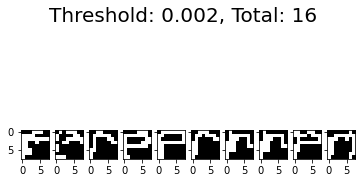

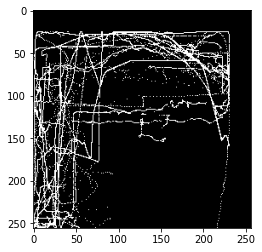

In [28]:
from scipy.spatial import distance

threshold, count = 0.002, 0
similar_bitmaps = []
similar_bitmap_file_name = []
for i in range(1, len(bitmap_data)):
    if (distance.cosine(low_dimension[0], low_dimension[i]) < threshold):
        similar_bitmap_file_name.append(file_names[i])
        if (count < 10):
            similar_bitmaps.append(bitmap_data[i])
        count += 1

os.chdir(CURR_RESULT_DIR)
plotImage(similar_bitmaps, 1, len(similar_bitmaps), file_name = f'Result({threshold}).png', super_title = f'Threshold: {threshold}, Total: {count}')

map_table = pd.read_csv(DATA_DIR + '/Map_Table.csv', header = 0)

os.chdir(IMAGE_DIR)

total_image = [ [ 0 for _ in range(256) ] for _ in range(256) ]
for file_name in similar_bitmap_file_name:
    image_file_name = map_table.loc[map_table[' LowDimNumber'] == int(file_name.split('th')[0])].iloc[0]['ImageNumber']
    curr_image = cv2.imread(f'Geolife_trajectory{image_file_name}.png', cv2.IMREAD_GRAYSCALE)
    for i in range(len(curr_image)):
        for j in range(len(curr_image[0])):
            if (curr_image[i][j] > 0):
                total_image[i][j] = 255

os.chdir(CURR_RESULT_DIR)
plotImage(total_image, 1, 1, file_name = f'Result of one image_{threshold}.png')